## WGAN-GP Model TF
---

In this tutorial, we only run a few iterations to see a result and how it looks like. To have better results, we recommend to train with more iterations.

## Import modules

In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from wgangp_model import WGAN_GP

2025-03-18 16:53:24.454175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742313204.478784 2772581 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742313204.483916 2772581 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 16:53:24.501565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


## Load preprocessed data

In [3]:
hdf5_file_name = "datasets/core_shell_particles_preprocessed_122500.h5"

# Open the HDF5 file
f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

# Combine X_train and X_test
X_transformed = np.concatenate((X_train, X_test), axis=0)
print("Shape of X_transformed:", X_transformed.shape)
np.random.seed(42)
np.random.shuffle(X_transformed)
X_transformed

Shape of X_transformed: (122500, 16)


array([[ 0.2929293 ,  0.47474748,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.6262626 ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.47474748,  0.03030303,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.93939394,  0.27272728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5555556 , -0.6969697 ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.25252524,  0.27272728,  0.        , ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)

In [4]:
X_transformed[0]

array([0.2929293 , 0.47474748, 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

## Load Preprocessor

In [5]:
# Load the preprocessors and scalers
preprocessor_path = "datasets/scaler_particle_geometries.pkl"
scaler_Qfwd_path = "datasets/scaler_Qfwd.pkl"
scaler_Qback_path = "datasets/scaler_Qback.pkl"

# Load the preprocessors and scalers
with open(preprocessor_path, "rb") as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, "rb") as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, "rb") as f:
    scaler_Qback = pickle.load(f)

/home/pwiecha/.pykeras/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/pwiecha/.pykeras/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/pwiecha/.pykeras/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.5.2 when using version 1.6.0. 

In [6]:
X_tensor = tf.convert_to_tensor(X_transformed, dtype=tf.float32)

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(X_tensor)
batch_size = 30625
dataloader = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Example: Iterating through the DataLoader
for batch in dataloader:
    print(batch.shape)

I0000 00:00:1742313207.311772 2772581 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17913 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:21:00.0, compute capability: 8.9


(30625, 16)
(30625, 16)
(30625, 16)
(30625, 16)


2025-03-18 16:53:27.427372: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Train WGANGP
---

In [7]:
# Define model parameters
latent_dim = 128
N_numerical = 2
N_mat_core = len(preprocessor.named_transformers_["cat"].categories_[0])
N_mat_shell = len(preprocessor.named_transformers_["cat"].categories_[1])
batch_size = 256
g_lr = 0.00005
d_lr = 0.00005
beta_1 = 0.5
beta_2 = 0.9
n_critic = 5
n_generator = 1
gradient_penalty_weight = 10
iterations = 1000
sample_interval = 500

In [8]:
# Create and train the WGAN-GP model
wgan_gp = WGAN_GP(
    latent_dim,
    N_numerical,
    N_mat_core,
    N_mat_shell,
    g_lr,
    d_lr,
    beta_1,
    beta_2,
    n_critic,
    n_generator,
    gradient_penalty_weight,
)

/home/pwiecha/.pykeras/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


  0%|          | 1/1000 [00:09<2:36:30,  9.40s/it]

Epoch: 0, Discriminator Loss: 1.1650683879852295, Generator Loss: 0.12016986310482025


 50%|█████     | 501/1000 [02:31<02:15,  3.68it/s]

Epoch: 500, Discriminator Loss: -0.5642874836921692, Generator Loss: -0.9364612698554993


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


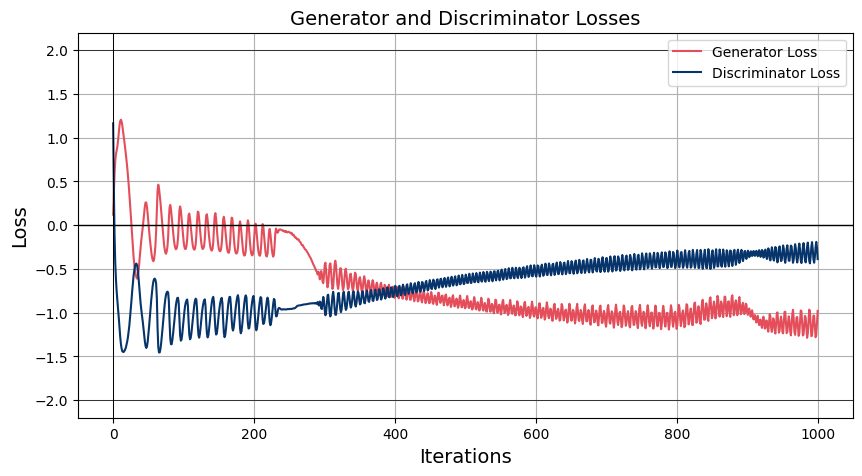

In [9]:
wgan_gp.train(X_transformed, iterations, sample_interval)

# Save the model
wgan_gp.generator.save("models/wgangp_generator.h5")

### Load Loss 
---

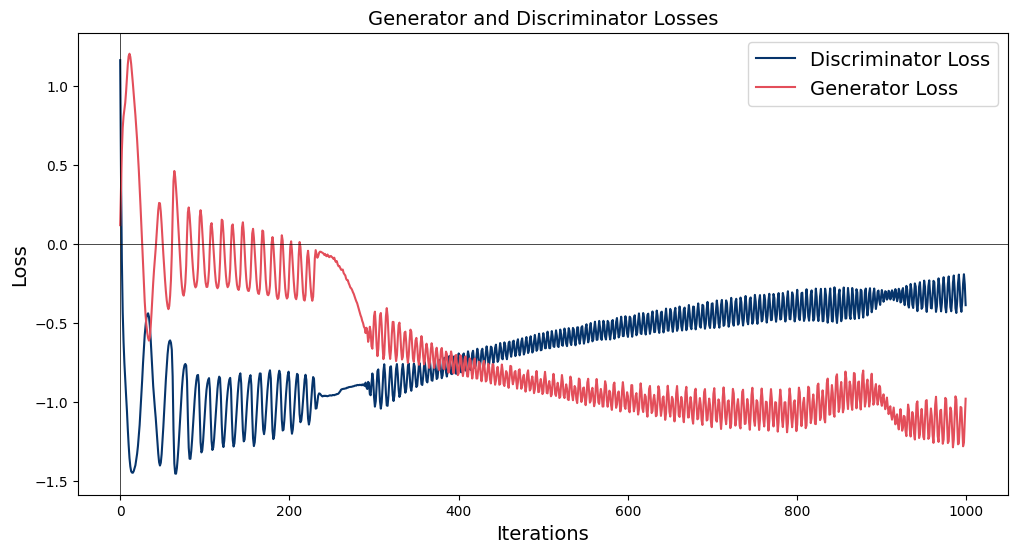

In [10]:
# load loss 
with open("models/wgangp_loss_data.pkl", "rb") as f:
    loss_data = pickle.load(f)

# Extract generator and critic losses
generator_loss = loss_data["generator_loss"]
critic_loss = loss_data["critic_loss"]

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(critic_loss, color="#06346B", label="Discriminator Loss")
plt.plot(generator_loss, color="#E34E5A", label="Generator Loss")
plt.axvline(0, color="black", linewidth=0.5)
plt.axhline(0, color="black", linewidth=0.5)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Generator and Discriminator Losses", fontsize=14)
plt.legend(fontsize=14, loc="upper right")

plt.show()